In [ ]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

#a)
# not inplemented but by looking at it.
# its  p = 1/2 to be in either C or B, thus its 1/4 in D and F, and 1/2 in E


In [4]:
#b)
# for nodes A to F
starting_state = np.array([1, 0, 0, 0, 0, 0])

transition_matrix = np.array([[0,    0,   0,   0,   0,   0],
                              [1/2,  0,   0,   0,   0,   0],
                              [1/2,  0,   0,   0,   0,   0],
                              [0,  1/2,   0,   1,   0,   0],
                              [0,  1/2, 1/2,   0,   1,   0],
                              [0,    0, 1/2,   0,   0,   1]])


old_state = starting_state
new_state = np.dot(transition_matrix, starting_state)

while not np.allclose(old_state ,new_state, rtol=1e-7):
    old_state = new_state
    new_state = np.dot(transition_matrix, old_state)

print("final state:" , new_state)


final state: [0.   0.   0.   0.25 0.5  0.25]


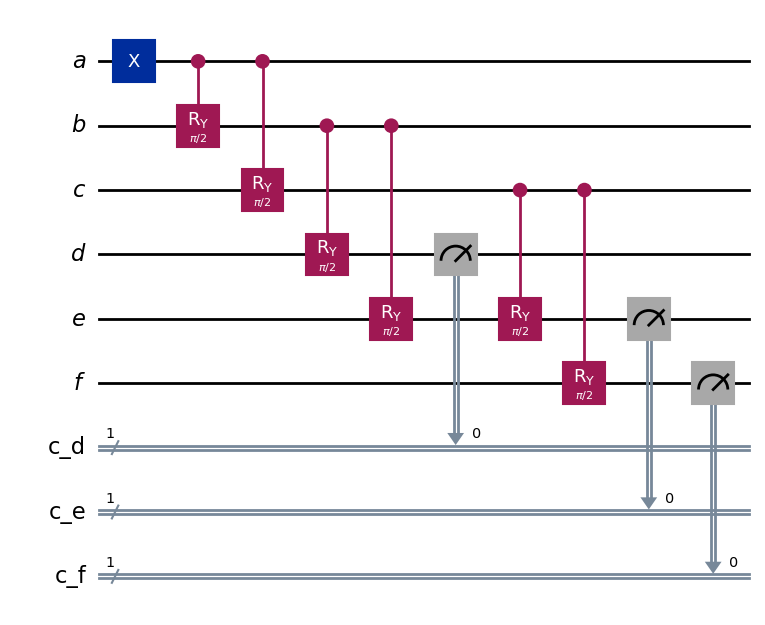

In [ ]:
# c)
# registers 
q_a, q_b, q_c, q_d, q_e, q_f = QuantumRegister(1, 'a'), QuantumRegister(1, 'b'), QuantumRegister(1, 'c'), QuantumRegister(1, 'd'), QuantumRegister(1, 'e'), QuantumRegister(1, 'f')
c_d, c_e, c_f = ClassicalRegister(1,'c_d'), ClassicalRegister(1,'c_e'), ClassicalRegister(1,'c_f')
qc = QuantumCircuit(q_a, q_b, q_c, q_d, q_e, q_f,
                    c_d, c_e, c_f,
                    name='ABC_Galton')

# initial state |a b c> = |0 0 0> , so set A = 1, ball starts at the top
qc.x(q_a)

# --- fan‑outs, each child is conditioned on the parent beeing 1, when controlled gate by parent onto child
theta = np.pi/2              # 50‑50 split
qc.cry(theta, q_a[0], q_b[0])          # A -> B
qc.cry(theta, q_a[0], q_c[0])          # A -> C

qc.cry(theta, q_b[0], q_d[0])   # B → D
qc.cry(theta, q_b[0], q_e[0])   # B → E
qc.cry(theta, q_c[0], q_e[0])   # C → E
qc.cry(theta, q_c[0], q_f[0])   # C → F


#qc.measure_all()
qc.measure(q_d[0], c_d[0])
qc.measure(q_e[0], c_e[0])
qc.measure(q_f[0], c_f[0])
qc.draw("mpl") # print with matplotlib


{'1 1 0': 1254, '0 0 0': 3733, '0 0 1': 595, '1 1 1': 624, '0 1 0': 1905, '0 1 1': 1249, '1 0 0': 640}
Interpreting (d e f):

000  |  3733 shots | No pin fired (B=0, C=0)
010  |  1905 shots | E fired (← B or C fired)
110  |  1254 shots | D fired (← B fired); E fired (← B or C fired)
011  |  1249 shots | E fired (← B or C fired); F fired (← C fired)
100  |   640 shots | D fired (← B fired)
111  |   624 shots | D fired (← B fired); E fired (← B or C fired); F fired (← C fired)
001  |   595 shots | F fired (← C fired)


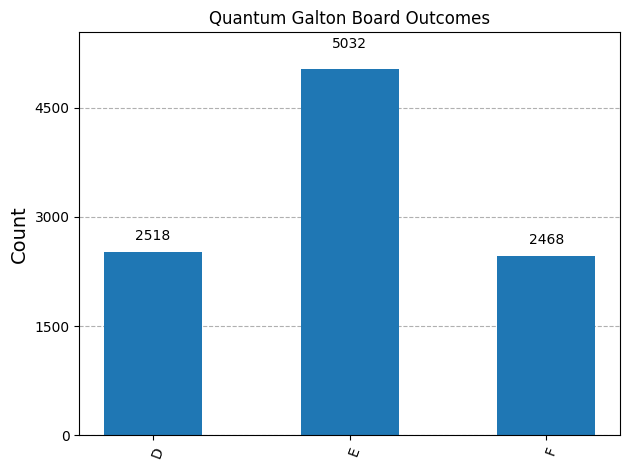

In [ ]:
# measurement
from qiskit_aer import AerSimulator # accelerated emulator Runtime?
from qiskit import transpile
from qiskit.visualization import plot_histogram

simulator = AerSimulator()
transp = transpile(qc, simulator)

result = simulator.run(transp, shots=10000).result()
counts = result.get_counts(transp)

# need to read | b c a > , when inputting it like a,b,c into the qcircuit from qiskit
print(counts)  

def interpret_counts(counts):
    print("Interpreting (d e f):\n")
    for key, value in sorted(counts.items(), key=lambda x: -x[1]):
        bits = key.replace(' ', '')  # remove spacing: "0 1 1" → "011"
        d, e, f = bits[0], bits[1], bits[2]

        explanation = []

        if d == '1':
            explanation.append("D fired (← B fired)")
        if e == '1':
            explanation.append("E fired (← B or C fired)")
        if f == '1':
            explanation.append("F fired (← C fired)")

        if not explanation:
            explanation = ["No pin fired (B=0, C=0)"]

        print(f"{bits}  | {value:>5} shots | {'; '.join(explanation)}")

def collapse_galton_outcomes(counts):
    outcome_counts = {'D': 0, 'E': 0, 'F': 0}
    for key, value in counts.items():
        bits = key.replace(' ', '')  # e.g. "1 0 0" → "100"
        d, e, f = bits[0], bits[1], bits[2]

        # i guess we can just count, it somehow works, "impossible" results are thus ignored, e.g. 000
        if d == '1':
            outcome_counts['D'] += value
        if e == '1':
            outcome_counts['E'] += value
        if f == '1':
            outcome_counts['F'] += value

    return outcome_counts


galton = collapse_galton_outcomes(counts)
interpret_counts(counts)

#plot_histogram(counts, title='Galton Board', color='blue', figsize=(10, 5))

plot_histogram(galton, title="Quantum Galton Board Outcomes") # should be approx 1/4, 1/2, 1/4